In [ ]:
import json
from datetime import datetime

# 讀取 JSON 檔案
with open(r'C:\Users\student\Desktop\disney\history_test.json', 'r', encoding='utf-8') as file:
    data = json.load(file)

# 新增一個鍵值對，儲存星期幾
for record in data:
    datetime_str = record['datetime']
    dt = datetime.strptime(datetime_str, '%Y-%m-%d %H:%M')
    record['weekday'] = dt.strftime('%A')

# 輸出結果
for record in data:
    print(f"日期: {record['datetime']}, 星期: {record['weekday']}")

# 如果需要將結果保存到新的 JSON 檔案中
with open(r'C:\Users\student\Desktop\disney\save_time.json', 'w', encoding='utf-8') as file:
    json.dump(data, file, ensure_ascii=False, indent=4)

In [1]:
# 導入必要的庫
import pandas as pd
import json
from datetime import timedelta

# 讀取 JSON 檔案
file_path = '/Users/chianlee/Desktop/disney/data/testing_data_sea.json'
file_path_names = '/Users/chianlee/Desktop/disney/data/sea_namelist.json'

with open(file_path, 'r', encoding='utf-8') as file:
    data = json.load(file)

with open(file_path_names, 'r', encoding='utf-8') as file:
    names = json.load(file)

In [2]:
# 轉換為 DataFrame
df_data = pd.DataFrame(data)
df_names = pd.DataFrame(names)

# 刪除 'FacilityName' 欄位並移除 'StandbyTime' 為 null 的行
df_data = df_data.drop(columns=['FacilityName'])
df_data = df_data[df_data['StandbyTime'].notna()]

# 顯示處理後的5筆數據
df_data.head(5)

,StandbyTime,FacilityID,UpdateTime,datetime
0,5,234,9:00,2024-07-31 07:36
2,False,202,9:00,2024-07-31 07:36
3,5,222,9:00,2024-07-31 07:36
4,5,236,9:00,2024-07-31 07:36
5,0,235,9:00,2024-07-31 07:36


In [3]:
# 解析日期時間欄位
df_data['UpdateTime'] = pd.to_datetime(df_data['UpdateTime'], format='%H:%M')
df_data['datetime'] = pd.to_datetime(df_data['datetime'])

# 將所有 datetime 欄位加上一小時
df_data['datetime'] = df_data['datetime'] + pd.Timedelta(hours=1)

# 提取日期並應用於 UpdateTime
df_data['UpdateTime'] = df_data.apply(
    lambda row: row['UpdateTime'].replace(year=row['datetime'].year, month=row['datetime'].month, day=row['datetime'].day),
    axis=1
)

# 顯示處理後的5筆數據
df_data.head(5)

,StandbyTime,FacilityID,UpdateTime,datetime
0,5,234,2024-07-31 09:00:00,2024-07-31 08:36:00
2,False,202,2024-07-31 09:00:00,2024-07-31 08:36:00
3,5,222,2024-07-31 09:00:00,2024-07-31 08:36:00
4,5,236,2024-07-31 09:00:00,2024-07-31 08:36:00
5,0,235,2024-07-31 09:00:00,2024-07-31 08:36:00


In [4]:
# 計算 UpdateTime 和 datetime 之間的時間差（以小時為單位）
df_data['time_difference'] = (df_data['datetime'] - df_data['UpdateTime'])

# 刪除時間差超過2小時的資料
df_filtered = df_data[df_data['time_difference'] <= timedelta(hours=2)]

# 刪除多餘的時間差欄位
df_filtered = df_filtered.drop(columns=['time_difference'])

# 顯示處理後的5筆數據
df_filtered.head(-5)

,StandbyTime,FacilityID,UpdateTime,datetime
0,5,234,2024-07-31 09:00:00,2024-07-31 08:36:00
2,False,202,2024-07-31 09:00:00,2024-07-31 08:36:00
3,5,222,2024-07-31 09:00:00,2024-07-31 08:36:00
4,5,236,2024-07-31 09:00:00,2024-07-31 08:36:00
5,0,235,2024-07-31 09:00:00,2024-07-31 08:36:00
...,...,...,...,...
3864,10,231,2024-07-31 18:18:00,2024-07-31 18:30:00
3868,50,218,2024-07-31 18:08:00,2024-07-31 18:30:00
3871,20,257,2024-07-31 18:24:00,2024-07-31 18:30:00
3873,5,258,2024-07-31 17:06:00,2024-07-31 18:30:00


In [5]:
# 合併數據框以添加英文設施名稱
df_filtered = df_filtered.merge(df_names[['FacilityID', 'FacilityEnglish']], on='FacilityID', how='left')

# 提取設施名稱和小時
df_filtered['Hour'] = df_filtered['datetime'].dt.hour

# 計算每個設施每小時的平均等候時間
df_filtered['StandbyTime'] = pd.to_numeric(df_filtered['StandbyTime'], errors='coerce')
average_wait_times = df_filtered.groupby(['FacilityEnglish', 'Hour'])['StandbyTime'].mean().reset_index()

# 顯示結果
average_wait_times.head(20)

,FacilityEnglish,Hour,StandbyTime
0,"20,000 Leagues Under the Sea",8,5.000000
1,"20,000 Leagues Under the Sea",9,26.818182
2,"20,000 Leagues Under the Sea",10,33.333333
3,"20,000 Leagues Under the Sea",11,32.083333
4,"20,000 Leagues Under the Sea",12,22.222222
...,...,...,...
95,DisneySea Transit Steamer Line (Mediterranean ...,8,5.000000
96,DisneySea Transit Steamer Line (Mediterranean ...,9,17.272727
97,DisneySea Transit Steamer Line (Mediterranean ...,10,12.083333
98,DisneySea Transit Steamer Line (Mediterranean ...,11,5.000000


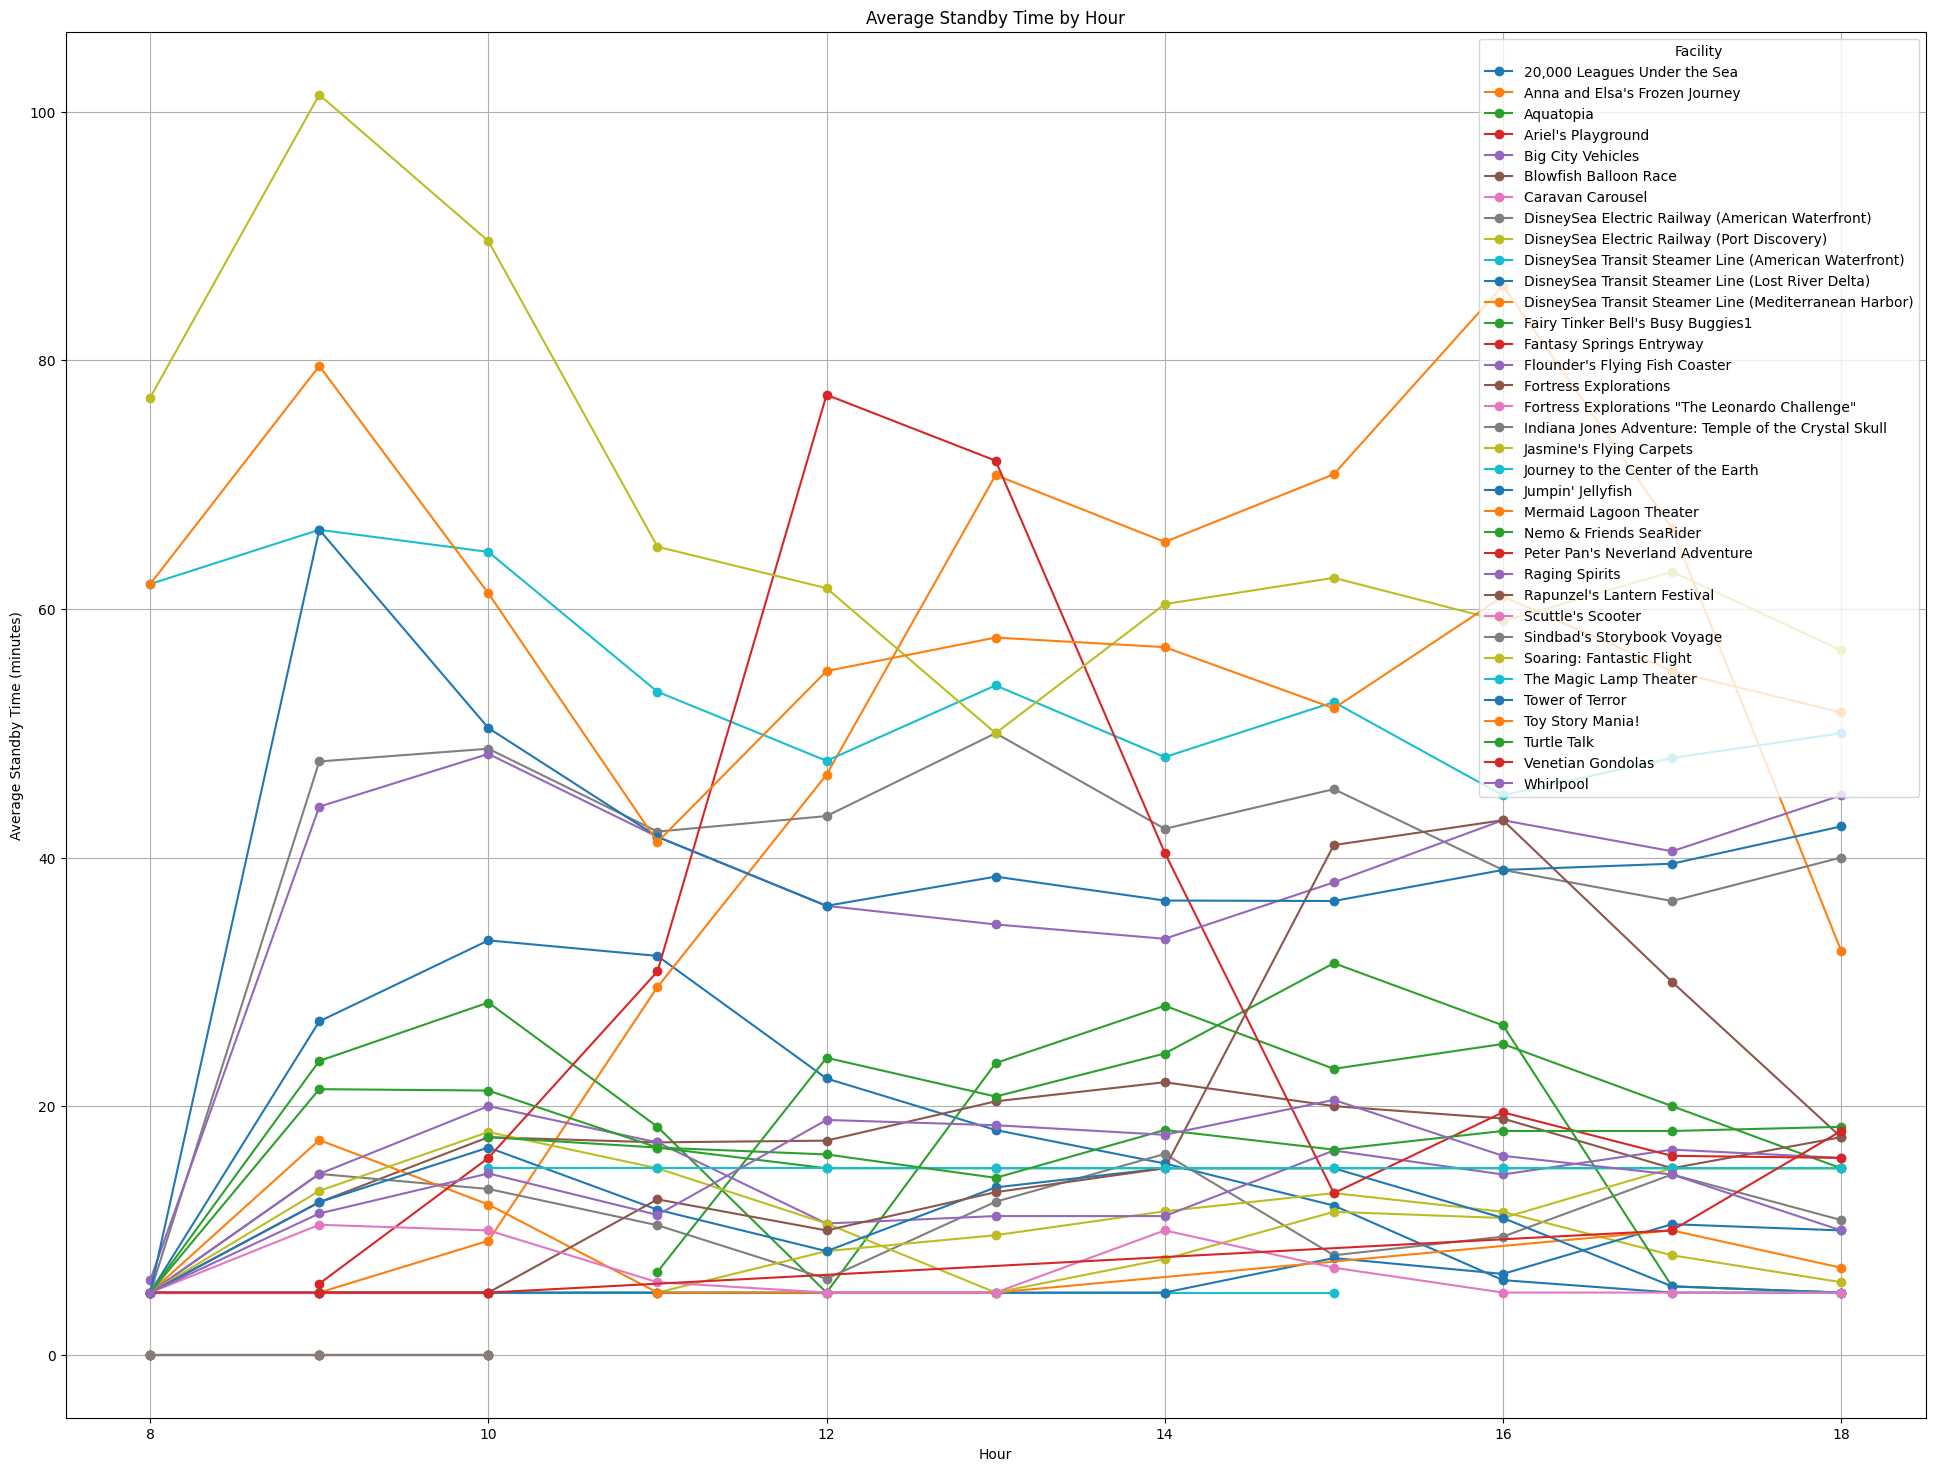

In [12]:
import matplotlib.pyplot as plt

# 設置圖表大小
plt.figure(figsize=(24, 18))

# 為每個設施畫折線
for facility in average_wait_times['FacilityEnglish'].unique():
    facility_data = average_wait_times[average_wait_times['FacilityEnglish'] == facility]
    plt.plot(facility_data['Hour'], facility_data['StandbyTime'], marker='o', label=facility)

# 添加圖例和標籤
plt.legend(title='Facility')
plt.xlabel('Hour')
plt.ylabel('Average Standby Time (minutes)')
plt.title('Average Standby Time by Hour')
plt.grid(True)
plt.show()

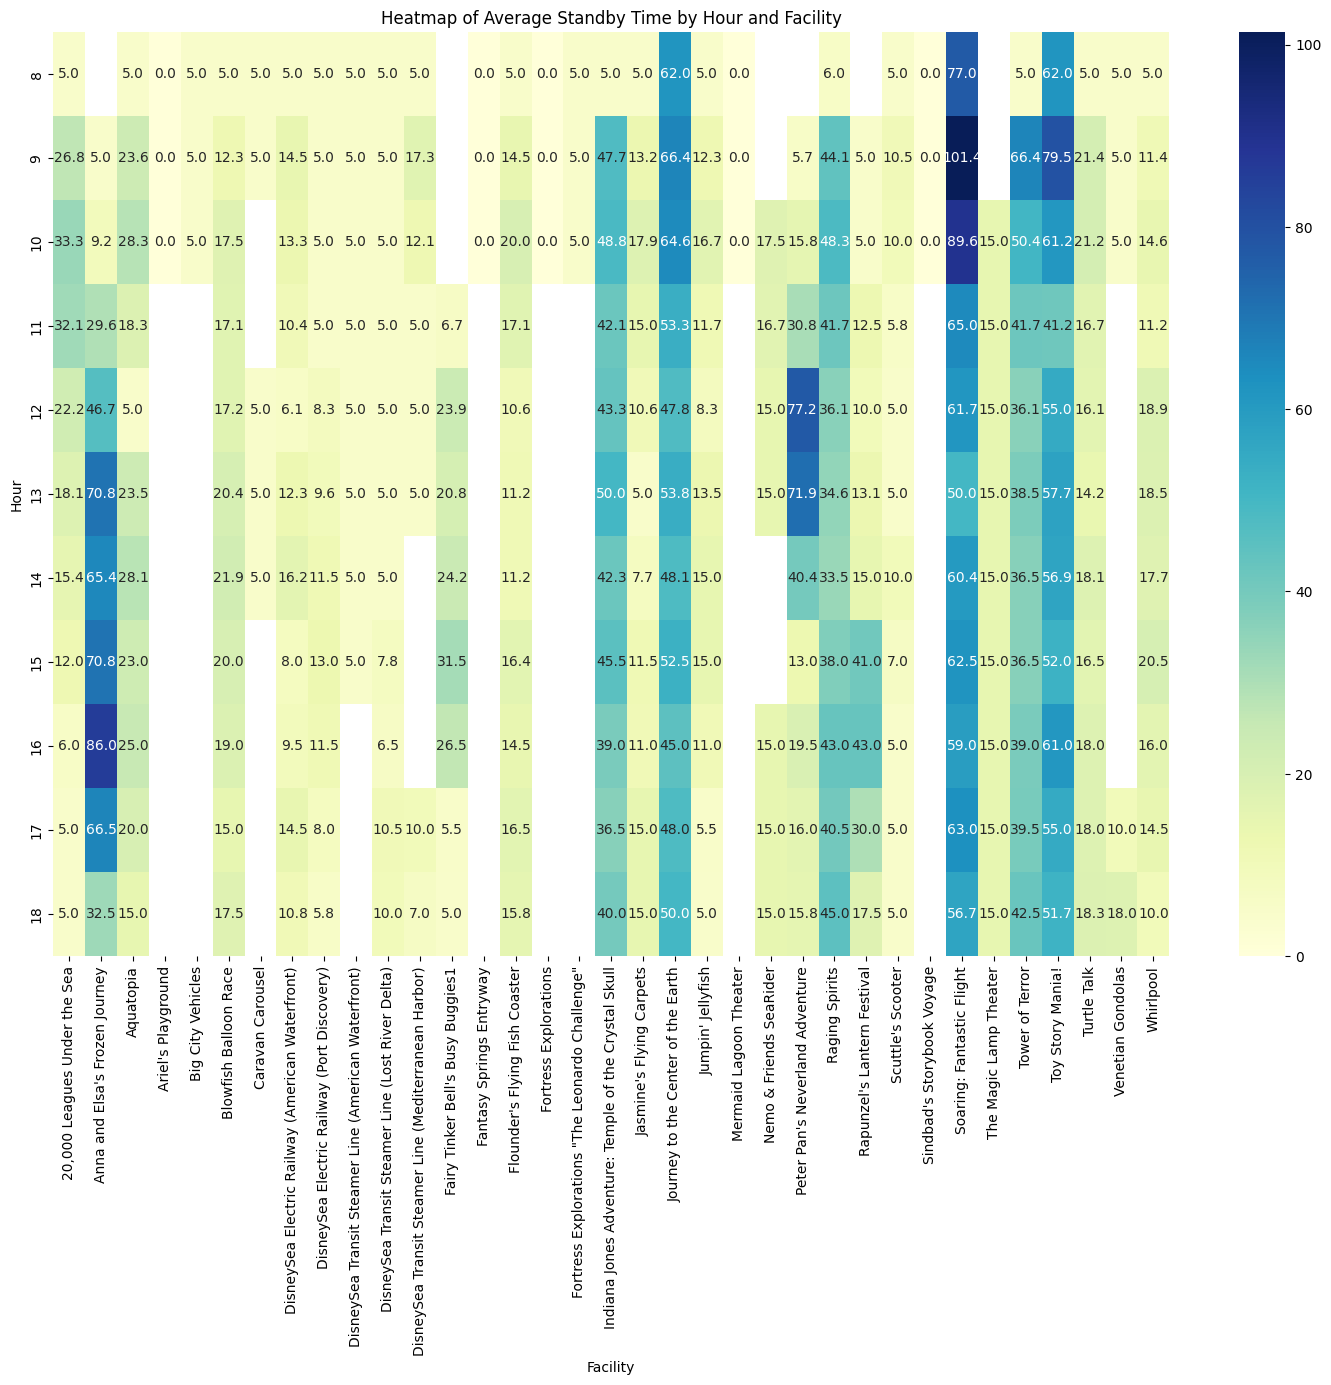

In [13]:
import seaborn as sns

# 設置圖表大小
plt.figure(figsize=(18, 12))

# 使用 Seaborn 繪製熱圖
sns.heatmap(pivot_df, annot=True, fmt=".1f", cmap="YlGnBu")

# 添加標題和標籤
plt.title('Heatmap of Average Standby Time by Hour and Facility')
plt.xlabel('Facility')
plt.ylabel('Hour')
plt.show()


In [ ]:
df_filtered.describe()

In [ ]:
df_filtered.shape

In [ ]:
df_filtered.isnull().sum()

In [ ]:
df_filtered.info()